In [25]:
import os
import numpy as np
import librosa
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt

import timeit
start_time = timeit.default_timer()



In [8]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from audiomentations import Compose, TimeStretch, PitchShift, AddGaussianNoise


# Define paths and parameters
DATASET_PATH = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac"
LABEL_FILE_PATH = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
NUM_CLASSES = 2  # Number of classes (bonafide and spoof)
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 5  # Duration of audio clips in seconds
N_MFCC = 13  # Number of MFCC coefficients
HOP_LENGTH = 512  # Hop length for MFCC extraction
WIN_LENGTH = 1024  # Window length for MFCC extraction

labels = {}
with open(LABEL_FILE_PATH, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    labels[file_name] = label

X = []
y = []

max_time_steps = 109  # Define the maximum time steps for your model

for file_name, label in labels.items():
    file_path = os.path.join(DATASET_PATH, file_name + ".flac")

    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Extract MFCC features using librosa
    mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, n_fft=WIN_LENGTH)

    # Ensure all MFCC features have the same width (time steps)
    if mfcc.shape[1] < max_time_steps:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_time_steps - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_time_steps]

    X.append(mfcc)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [9]:
from sklearn.model_selection import train_test_split

# Data augmentation using audiomentations
augment = Compose([
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
])

X_augmented = [augment(samples=x, sample_rate=SAMPLE_RATE) for x in X]

# Split the data into training (80%) and the rest (20%)
X_train, X_rest, y_train, y_rest = train_test_split(X_augmented, y, test_size=0.2, random_state=42)

# Further split the rest into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

/home/jonat/miniconda3/envs/ASV/lib/python3.9/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=109
  warnings.warn(


In [14]:
# Load both Model 1 , Model 2
model1 = load_model('models/agamjeet-model-new.h5') # Replace with the path to Model 1's saved file
model2 = load_model('models/speaker_verification_model.h5') 
model3 = load_model('models/gautham-model-new.h5')

# Define the EnsembleModel
class EnsembleModel(tf.keras.Model):
    def __init__(self, modelA, modelB, modelC):
        super(EnsembleModel, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.flatten = tf.keras.layers.Flatten()
        self.classifier = tf.keras.layers.Dense(200, activation='softmax')

    def call(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x3 = self.modelC(x)
        x1 = self.flatten(x1)
        x2 = self.flatten(x2)
        x3 = self.flatten(x3)
        x = tf.concat([x1, x2, x3], axis=1)
        out = self.classifier(x)
        return out


# Create an instance of the EnsembleModel
ensemble_model = EnsembleModel( model1,model2,model3)


In [22]:
# Freeze model parameters
for layer in ensemble_model.layers:
    layer.trainable = False

# Unfreeze the classifier
ensemble_model.classifier.trainable = True

# Define a function for training
def train(model, num_epochs, train_dataloader, val_dataloader, optimizer, loss_fn, metrics, batch_size):
    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []

    for epoch in range(num_epochs):
        model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)
        train_loss_epoch = 0.0
        train_acc_epoch = 0.0

        for x_train, y_train in train_dataloader:
            # One-hot encode your labels
            y_train_one_hot = tf.one_hot(y_train, depth=200)
            
            with tf.GradientTape() as tape:
                y_pred = model(x_train)
                loss_value = loss_fn(y_train_one_hot, y_pred)
            gradients = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            train_loss_epoch += loss_value
            train_acc_epoch += metrics[0](y_train_one_hot, y_pred)

        train_loss_epoch /= len(train_dataloader)
        train_acc_epoch /= len(train_dataloader)
        train_loss_array.append(train_loss_epoch)
        train_acc_array.append(train_acc_epoch)

        val_loss_epoch = 0.0
        val_acc_epoch = 0.0

        for x_val, y_val in val_dataloader:
            # One-hot encode the ground truth labels for validation
            y_val_one_hot = tf.one_hot(y_val, depth=200)  # Assuming 200 classes

            y_val_pred = model(x_val)
            val_loss = loss_fn(y_val_one_hot, y_val_pred)
            val_acc = metrics[0](y_val_one_hot, y_val_pred)
            val_loss_epoch += val_loss
            val_acc_epoch += val_acc

        val_loss_epoch /= len(val_dataloader)
        val_acc_epoch /= len(val_dataloader)
        val_loss_array.append(val_loss_epoch)
        val_acc_array.append(val_acc_epoch)

    return model, train_loss_array, train_acc_array, val_loss_array, val_acc_array


In [23]:
# Create or load your training and validation datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Define batch size
batch_size = 32

# Create data loaders
train_dataloader = train_dataset.batch(batch_size).shuffle(buffer_size=1000)
val_dataloader = val_dataset.batch(batch_size)

# Define hyperparameters
num_epochs = 20
learning_rate = 0.001
batch_size = 32

# Define the loss function and evaluation metrics
loss_fn = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.keras.metrics.BinaryAccuracy()]

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Train the ensemble model
ensemble_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array = train(
    ensemble_model, num_epochs, train_dataloader, val_dataloader, optimizer, loss_fn, metrics, batch_size
)

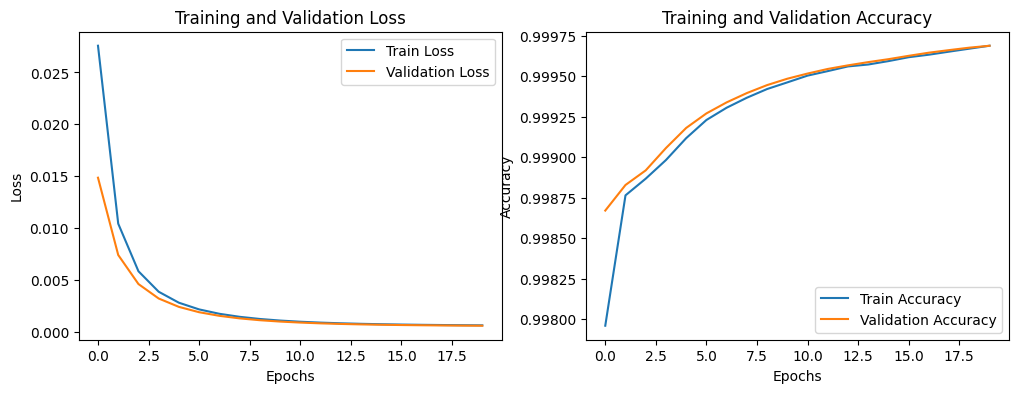


Training results:
	Min val loss 0.0006 was achieved during iteration #20
	Val accuracy during min val loss is 0.9997


In [26]:
# Visualize training results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_loss_array, label='Train Loss')
plt.plot(range(num_epochs), val_loss_array, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc_array, label='Train Accuracy')
plt.plot(range(num_epochs), val_acc_array, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Find and print minimum validation loss and associated accuracy
min_loss = min(val_loss_array)
min_loss_iteration = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_iteration]

print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min_loss, min_loss_iteration + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [28]:
# Save the ensemble model to a directory
model_save_path = 'models/test-ensemble'
tf.keras.models.save_model(ensemble_model, model_save_path)

INFO:tensorflow:Assets written to: models/test-ensemble/assets


INFO:tensorflow:Assets written to: models/test-ensemble/assets


In [29]:
# You can also specify additional options, like saving in the TensorFlow SavedModel format:
tf.keras.models.save_model(ensemble_model, model_save_path, save_format='tf')

INFO:tensorflow:Assets written to: models/test-ensemble/assets


INFO:tensorflow:Assets written to: models/test-ensemble/assets
